In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Final2022/bionet')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchsummary import summary
import numpy as np
import math
import os
import psutil
print(torch.__version__)
print(torch.cuda.get_device_name(0))

1.12.0+cu113
Tesla V100-SXM2-16GB


In [9]:
Batch_size=128
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.Resize(32),
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
a="/content/drive/My Drive/Final2022/data/ecoset-cifar10/train"
b="/content/drive/My Drive/Final2022/data/ecoset-cifar10/test"
trainingset1=datasets.ImageFolder(root=a,transform=transform)
testset1=datasets.ImageFolder(root=b,transform=transform)
'''trainingset1=datasets.ImageFolder(root="../data/Cifar10/train_cifar10",transform=transform)
testset1=datasets.ImageFolder(root="../data/Cifar10/test_cifar10",transform=transform)'''
trainloader1=DataLoader(trainingset1,batch_size=Batch_size,shuffle=True,num_workers=4)
testloader1=DataLoader(testset1,batch_size=Batch_size,shuffle=False,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
Batch_Size = 256
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

'''cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}'''

class GaborConv2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
        padding_mode="zeros",
    ):
        super().__init__()

        self.is_calculated = False

        self.conv_layer = nn.modules.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
        self.kernel_size = self.conv_layer.kernel_size

        # small addition to avoid division by zero
        self.delta = 1e-3

        # freq, theta, sigma are set up according to S. Meshgini,
        # A. Aghagolzadeh and H. Seyedarabi, "Face recognition using
        # Gabor filter bank, kernel principal component analysis
        # and support vector machine"
        self.freq = nn.Parameter((math.pi / 2) * math.sqrt(2) ** (-torch.randint(0, 5, (out_channels, in_channels))).type(torch.Tensor),requires_grad=True, )
        self.theta = nn.Parameter((math.pi / 8) * torch.randint(0, 8, (out_channels, in_channels)).type(torch.Tensor),requires_grad=True,)
        self.sigma = nn.Parameter(math.pi / self.freq, requires_grad=True)
        self.psi = nn.Parameter(math.pi * torch.rand(out_channels, in_channels), requires_grad=True)
        self.x0 = nn.Parameter(torch.ceil(torch.Tensor([self.kernel_size[0] / 2]))[0], requires_grad=False)
        self.y0 = nn.Parameter(torch.ceil(torch.Tensor([self.kernel_size[1] / 2]))[0], requires_grad=False)
        self.y, self.x = torch.meshgrid(
            [torch.linspace(-self.x0 + 1, self.x0 + 0, self.kernel_size[0]),
             torch.linspace(-self.y0 + 1, self.y0 + 0, self.kernel_size[1]),])
        self.y = nn.Parameter(self.y)
        self.x = nn.Parameter(self.x)
        self.weight = nn.Parameter(torch.empty(self.conv_layer.weight.shape, requires_grad=True),requires_grad=True,)


        self.register_parameter("freq", self.freq)
        self.register_parameter("theta", self.theta)
        self.register_parameter("sigma", self.sigma)
        self.register_parameter("psi", self.psi)
        self.register_parameter("x_shape", self.x0)
        self.register_parameter("y_shape", self.y0)
        self.register_parameter("y_grid", self.y)
        self.register_parameter("x_grid", self.x)
        self.register_parameter("weight", self.weight)

    def forward(self, input_tensor):
        if self.training:
            self.calculate_weights()
            #print(self.conv_layer.weight.data.shape)
            self.is_calculated = False
        if not self.training:
            if not self.is_calculated:
                self.calculate_weights()
                self.is_calculated = True
        return self.conv_layer(input_tensor)

    def calculate_weights(self):
        for i in range(self.conv_layer.out_channels):
            for j in range(self.conv_layer.in_channels):
                sigma = self.sigma[i, j].expand_as(self.y)
                freq = self.freq[i, j].expand_as(self.y)
                theta = self.theta[i, j].expand_as(self.y)
                psi = self.psi[i, j].expand_as(self.y)

                rotx = self.x * torch.cos(theta) + self.y * torch.sin(theta)
                roty = -self.x * torch.sin(theta) + self.y * torch.cos(theta)

                g = torch.exp(-0.5 * ((rotx ** 2 + roty ** 2) / (sigma + self.delta) ** 2))
                g = g * torch.cos(freq * rotx + psi)
                g = g / (2 * math.pi * sigma ** 2)
                self.conv_layer.weight.data[i, j] = g

class GaborConvFixed(nn.Module):
    def __init__(self,
          in_channels,
          out_channels,
          input_dict,
          kernel_size,
          stride=1,
          padding=0,
          dilation=1,
          groups=1,
          bias=False,
          padding_mode="zeros",
          ):
      super().__init__()
      self.input_dict=input_dict
      if self.input_dict==None:
          self.input_dict = {  # 'ksize': (127, 127),
            'ksize': (31, 31),
            'gammas': [0.5],
            #           'bs': np.linspace(0.4, 2.6, num=3),  # 0.4, 1, 1.8, 2.6
            #           'bs': np.linspace(0.4, 2.6, num=5),
            'bs': np.linspace(1, 2.6, num=3).tolist(),
            #           'bs': np.linspace(1, 2.6, num=5),
            #           'sigmas': [4, 8, 16],  # , 32
            'sigmas': [8],
            'thetas': np.linspace(0, np.pi, 4, endpoint=False).tolist(),
            'psis': [np.pi / 2, 3 * np.pi / 2]}
      
      self.ksize = self.input_dict["ksize"]
      self.sigmas = self.input_dict["sigmas"]
      self.bs = self.input_dict["bs"]
      self.gammas = self.input_dict["gammas"]
      self.thetas = self.input_dict["thetas"]
      self.psis = self.input_dict["psis"]

      self.conv_layer = nn.modules.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
      
      self.weight = nn.Parameter(torch.empty(self.conv_layer.weight.shape, requires_grad=False),requires_grad=False,)

    def calc_lambda(self, sigma, bandwidth):
      p = 2**bandwidth
      c = np.sqrt(np.log(2)/2)
      return sigma * np.pi / c  * (p - 1) / (p + 1)
    
    def forward(self, input_tensor):
      self.calculate_weights()
      return self.conv_layer(input_tensor)
    
    def calculate_weights(self):
      for i in range(self.conv_layer.out_channels):
          for j in range(self.conv_layer.in_channels):
              for sigma in self.sigmas:
                for theta in self.thetas:
                    # for lambd in lambdas:
                    for b in self.bs:
                        lambd = self.calc_lambda(sigma, b)
                        for gamma in self.gammas:
                            for psi in self.psis:
                                gf = cv2.getGaborKernel(self.ksize, sigma, theta,lambd, gamma, psi, ktype=cv2.CV_64F)
                                self.conv_layer.weight.data[i, j] = torch.tensor(gf)

class VGG(nn.Module):
    
    def __init__(self, vgg_name, param=None):
        super(VGG, self).__init__()
        self.param=param
        self.Gabor_out_channels=64
        '''if param:
          self.g0=GaborConvFixed(in_channels=3, out_channels= 24, input_dict=self.param,kernel_size=(31, 31) ,padding=15)
        else:'''
        self.g0=GaborConv2d(in_channels=5, out_channels= self.Gabor_out_channels, kernel_size=(31, 31),padding=15)
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,10),
        )
#         self.classifier = nn.Linear(512,10)

        self._initialize_weight()
        
    def forward(self, x):
      x=self.opponency_encoder(x)
      out = self.features(self.g0(x))
      # 在进入
      out = out.view(out.size(0), -1)
      #out = self.classifier(out)
      return out
    def opponency_encoder(self,data_tensor):
      num, channel, row, col=data_tensor.shape
      inputshape=(num,int(channel/3),row,col)
      r = data_tensor[:, 0, :, :]
      g = data_tensor[:, 1, :, :]
      b = data_tensor[:, 2, :, :]
      I = ((r + g + b) / 3).reshape(inputshape)
      R = torch.clamp(r - (g + b) / 2,min=0.0)
      G = torch.clamp(g - (r - b) / 2,min=0.0)
      B = torch.clamp(b - (r + g) / 2,min=0.0)
      Y = torch.clamp((r + g) / 2 - (r - g) / 2 - b,min=0.0)
      RG = torch.clamp(R - G,min=0.0).reshape(inputshape)
      GR = torch.clamp(G - R,min=0.0).reshape(inputshape)
      BY = torch.clamp(B - Y,min=0.0).reshape(inputshape)
      YB = torch.clamp(Y - B,min=0.0).reshape(inputshape)
      return torch.cat((I,RG,GR,BY,YB),1)
    # make layers

    def _make_layers(self, cfg):
        layers = []
        in_channels = self.Gabor_out_channels # RGB 初始通道为3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # kernel_size 为 2 x 2,然后步长为2
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # 都是(3.3)的卷积核
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]  # RelU
                in_channels = x  # 重定义通道
#         layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    # 初始化参数
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # xavier is used in VGG's paper
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
input_dict = {  # 'ksize': (127, 127),
            'ksize': (31, 31),
            'gammas': [0.5],
            #           'bs': np.linspace(0.4, 2.6, num=3),  # 0.4, 1, 1.8, 2.6
            #           'bs': np.linspace(0.4, 2.6, num=5),
            'bs': np.linspace(1, 2.6, num=3).tolist(),
            #           'bs': np.linspace(1, 2.6, num=5),
            #           'sigmas': [4, 8, 16],  # , 32
            'sigmas': [8],
            'thetas': np.linspace(0, np.pi, 4, endpoint=False).tolist(),
            'psis': [np.pi / 2, 3 * np.pi / 2]}
      
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = VGG('VGG16').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

In [5]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std


def get_acc(outputs, label):
    total = outputs.shape[0]
    probs, pred_y = outputs.data.max(dim=1) # 得到概率
    correct = (pred_y == label).sum().data
    return correct / total


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss

def train(net, trainloader, testloader, epoches, optimizer , criterion, scheduler , path = './model.pth', writer = None ,verbose = False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_acc = 0
    train_acc_list, test_acc_list = [],[]
    train_loss_list, test_loss_list = [],[]
    lr_list  = []
    for i in range(epoches):
        start = time.time()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            # 释放内存
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            # formard
            outputs = net(im)
            loss = criterion(outputs,label)
            # backward
            loss.backward()
            # 更新参数
            optimizer.step()

            train_loss += loss.data
            # probs, pred_y = outputs.data.max(dim=1) # 得到概率
            # # 正确的个数
            # train_acc += (pred_y==label).sum().item()
            # # 总数
            # total += label.size(0)
            train_acc += get_acc(outputs,label)
            # 打印下载进度
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc * 100 / len(trainloader)
        if verbose:
            train_acc_list.append(train_acc.item())
            train_loss_list.append(train_loss.item())
    #     print('train_loss:{:.6f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')  
        # 记录学习率
        lr = optimizer.param_groups[0]['lr']
        if verbose:
            lr_list.append(lr)
        # 更新学习率
        scheduler.step(train_loss)
        if testloader is not None:
            net.eval()
            with torch.no_grad():
                for step,data in enumerate(testloader,start=0):
                    im,label = data
                    im = im.to(device)
                    label = label.to(device)
                    # 释放内存
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
                    outputs = net(im)
                    loss = criterion(outputs,label)
                    test_loss += loss.data
                    # probs, pred_y = outputs.data.max(dim=1) # 得到概率
                    # test_acc += (pred_y==label).sum().item()
                    # total += label.size(0)
                    test_acc += get_acc(outputs,label)
                    rate = (step + 1) / len(testloader)
                    a = "*" * int(rate * 50)
                    b = "." * (50 - int(rate * 50))
                    print('\r test  {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
            test_loss = test_loss / len(testloader)
            test_acc = test_acc * 100 / len(testloader)
            if verbose:
                test_loss_list.append(test_loss.item())
                test_acc_list.append(test_acc.item())
            end = time.time()
            print(
                '\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoches, train_loss, train_acc, test_loss, test_acc,lr), end='')
        else:
            end = time.time()
            print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(i+1,epoches,train_loss,train_acc,lr),end = '')
        time_ = int(end - start)
        h = time_ / 3600
        m = time_ % 3600 /60
        s = time_ % 60
        time_str = "\tTime %02d:%02d" % ( m, s)
        # ====================== 使用 tensorboard ==================
        if writer is not None:
            writer.add_scalars('Loss', {'train': train_loss,
                                    'valid': test_loss}, i+1)
            writer.add_scalars('Acc', {'train': train_acc ,
                                   'valid': test_acc}, i+1)
            writer.add_scalars('Learning Rate',lr,i+1)
        # =========================================================
        # 打印所用时间
        print(time_str)
        # 如果取得更好的准确率，就保存模型
        if test_acc > best_acc:
            torch.save(net,path)
            best_acc = test_acc
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['test_acc'] = test_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['test_loss'] = test_loss_list
    Lr = lr_list
    return Acc, Loss, Lr
import matplotlib.pyplot as plt
def plot_history(epoches, Acc, Loss, lr):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, lr)
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

In [ ]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 1e-100) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)

import time
epoch = 200
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/OpponencyEcoGaborVGG16.pth'
Acc, Loss, Lr = train(net, trainloader1, testloader1, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

文件已存在


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 train   1|200 71 %  [***********************************->...............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [  1/200]  Train Loss:1.827045  Train Acc:36.13% Test Loss:1.196129  Test Acc:59.86%  Learning Rate:0.100000	Time 02:28
 train   2|200 84 %  [******************************************->........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [  2/200]  Train Loss:1.344040  Train Acc:52.27% Test Loss:0.830748  Test Acc:72.73%  Learning Rate:0.100000	Time 05:13
 train   3|200 91 %  [*********************************************->.....] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [  3/200]  Train Loss:1.199330  Train Acc:57.96% Test Loss:0.931385  Test Acc:71.29%  Learning Rate:0.100000	Time 05:15
 train   4|200 73 %  [************************************->..............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [  4/200]  Train Loss:1.113892  Train Acc:61.14% Test Loss:0.629366  Test Acc:80.41%  Learning Rate:0.100000	Time 05:14
 train   5|200 70 %  [***********************************->...............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [  5/200]  Train Loss:1.061863  Train Acc:63.17% Test Loss:0.583543  Test Acc:81.59%  Learning Rate:0.100000	Time 05:19
 train   6|200 70 %  [***********************************->...............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [  6/200]  Train Loss:1.026997  Train Acc:64.42% Test Loss:0.561818  Test Acc:82.32%  Learning Rate:0.100000	Time 05:16
 train   7|200 67 %  [*********************************->.................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [  7/200]  Train Loss:0.985287  Train Acc:66.27% Test Loss:0.583548  Test Acc:82.02%  Learning Rate:0.100000	Time 05:13
 train   8|200 87 %  [*******************************************->.......] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [  8/200]  Train Loss:0.951563  Train Acc:67.02% Test Loss:0.840572  Test Acc:71.56%  Learning Rate:0.100000	Time 05:16
 train   9|200  2 %  [*->.................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [  9/200]  Train Loss:0.941229  Train Acc:67.82% Test Loss:0.468391  Test Acc:84.81%  Learning Rate:0.100000	Time 05:12
 train  10|200 18 %  [*********->.........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 10/200]  Train Loss:0.923787  Train Acc:68.44% Test Loss:0.821615  Test Acc:72.92%  Learning Rate:0.100000	Time 05:12
 train  11|200 88 %  [********************************************->......] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 11/200]  Train Loss:0.898580  Train Acc:69.28% Test Loss:0.597823  Test Acc:81.11%  Learning Rate:0.100000	Time 05:15
 train  12|200 55 %  [***************************->.......................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 12/200]  Train Loss:0.898637  Train Acc:69.44% Test Loss:0.819244  Test Acc:75.13%  Learning Rate:0.100000	Time 05:20
 train  13|200 50 %  [*************************->.........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 13/200]  Train Loss:0.877957  Train Acc:70.19% Test Loss:0.506201  Test Acc:84.54%  Learning Rate:0.100000	Time 05:25
 train  14|200 53 %  [**************************->........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 14/200]  Train Loss:0.870271  Train Acc:70.37% Test Loss:0.418004  Test Acc:86.58%  Learning Rate:0.100000	Time 05:25
 train  15|200 44 %  [**********************->............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 15/200]  Train Loss:0.849745  Train Acc:71.02% Test Loss:0.493204  Test Acc:83.88%  Learning Rate:0.100000	Time 05:24
 train  16|200 74 %  [*************************************->.............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 16/200]  Train Loss:0.845430  Train Acc:71.28% Test Loss:0.396770  Test Acc:88.53%  Learning Rate:0.100000	Time 05:18
 train  17|200 93 %  [**********************************************->....] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 17/200]  Train Loss:0.840110  Train Acc:71.33% Test Loss:0.408393  Test Acc:87.44%  Learning Rate:0.100000	Time 05:21
 train  18|200 37 %  [******************->................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 18/200]  Train Loss:0.829386  Train Acc:71.89% Test Loss:0.634495  Test Acc:80.26%  Learning Rate:0.100000	Time 05:21
 train  19|200 25 %  [************->......................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 19/200]  Train Loss:0.824106  Train Acc:72.25% Test Loss:0.580069  Test Acc:82.34%  Learning Rate:0.100000	Time 05:20
 train  20|200 73 %  [************************************->..............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 20/200]  Train Loss:0.805605  Train Acc:72.72% Test Loss:0.345853  Test Acc:88.82%  Learning Rate:0.100000	Time 05:21
 train  21|200 37 %  [******************->................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 21/200]  Train Loss:0.803639  Train Acc:72.89% Test Loss:0.413332  Test Acc:86.87%  Learning Rate:0.100000	Time 05:18
 train  22|200 66 %  [*********************************->.................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 22/200]  Train Loss:0.799482  Train Acc:72.75% Test Loss:0.581443  Test Acc:81.85%  Learning Rate:0.100000	Time 05:23
 train  23|200  1 %  [->..................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 23/200]  Train Loss:0.791829  Train Acc:73.28% Test Loss:0.432317  Test Acc:86.51%  Learning Rate:0.100000	Time 05:18
 train  24|200 41 %  [********************->..............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 24/200]  Train Loss:0.796831  Train Acc:73.05% Test Loss:0.720277  Test Acc:76.70%  Learning Rate:0.100000	Time 05:11
 train  25|200 73 %  [************************************->..............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 25/200]  Train Loss:0.790682  Train Acc:73.23% Test Loss:0.459856  Test Acc:85.13%  Learning Rate:0.100000	Time 05:17
 train  26|200 39 %  [*******************->...............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 26/200]  Train Loss:0.792903  Train Acc:73.22% Test Loss:0.368487  Test Acc:88.06%  Learning Rate:0.100000	Time 05:17
 train  27|200 61 %  [******************************->....................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 27/200]  Train Loss:0.782085  Train Acc:73.50% Test Loss:0.675537  Test Acc:78.62%  Learning Rate:0.100000	Time 05:27
 train  28|200 26 %  [*************->.....................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 28/200]  Train Loss:0.771504  Train Acc:73.86% Test Loss:0.521013  Test Acc:82.25%  Learning Rate:0.100000	Time 05:27
 train  29|200 32 %  [****************->..................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 29/200]  Train Loss:0.777973  Train Acc:73.63% Test Loss:0.481659  Test Acc:85.72%  Learning Rate:0.100000	Time 05:20
 train  30|200 16 %  [********->..........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 30/200]  Train Loss:0.767540  Train Acc:74.03% Test Loss:0.467993  Test Acc:84.89%  Learning Rate:0.100000	Time 05:23
 train  31|200 32 %  [****************->..................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 31/200]  Train Loss:0.770352  Train Acc:73.90% Test Loss:0.373455  Test Acc:88.58%  Learning Rate:0.100000	Time 05:29
 train  32|200 41 %  [********************->..............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 32/200]  Train Loss:0.766434  Train Acc:73.93% Test Loss:0.487685  Test Acc:84.51%  Learning Rate:0.100000	Time 05:22
 train  33|200 49 %  [************************->..........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 33/200]  Train Loss:0.764634  Train Acc:74.16% Test Loss:0.436689  Test Acc:86.25%  Learning Rate:0.100000	Time 05:25
 train  34|200 15 %  [*******->...........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 34/200]  Train Loss:0.763653  Train Acc:74.29% Test Loss:0.536322  Test Acc:83.67%  Learning Rate:0.100000	Time 05:38
 train  35|200 55 %  [***************************->.......................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 35/200]  Train Loss:0.757418  Train Acc:74.28% Test Loss:0.541748  Test Acc:82.70%  Learning Rate:0.100000	Time 05:33
 train  36|200 17 %  [********->..........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 36/200]  Train Loss:0.759371  Train Acc:74.44% Test Loss:1.381244  Test Acc:61.40%  Learning Rate:0.100000	Time 05:29
 train  37|200 78 %  [***************************************->...........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 37/200]  Train Loss:0.761336  Train Acc:74.29% Test Loss:0.515223  Test Acc:84.06%  Learning Rate:0.100000	Time 05:27
 train  38|200 37 %  [******************->................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 38/200]  Train Loss:0.759926  Train Acc:74.30% Test Loss:1.092007  Test Acc:64.28%  Learning Rate:0.100000	Time 05:21
 train  39|200 76 %  [**************************************->............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 39/200]  Train Loss:0.759789  Train Acc:74.49% Test Loss:0.684411  Test Acc:78.88%  Learning Rate:0.100000	Time 05:19
 train  40|200 37 %  [******************->................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 40/200]  Train Loss:0.754320  Train Acc:74.75% Test Loss:0.546687  Test Acc:83.24%  Learning Rate:0.100000	Time 05:19
 train  41|200 61 %  [******************************->....................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 41/200]  Train Loss:0.748215  Train Acc:74.83% Test Loss:1.241113  Test Acc:65.53%  Learning Rate:0.100000	Time 05:17
 train  42|200 85 %  [******************************************->........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 42/200]  Train Loss:0.752928  Train Acc:74.46% Test Loss:0.423571  Test Acc:86.30%  Learning Rate:0.100000	Time 05:15
 train  43|200 33 %  [****************->..................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 43/200]  Train Loss:0.748632  Train Acc:74.78% Test Loss:0.413149  Test Acc:86.65%  Learning Rate:0.100000	Time 05:13
 train  44|200  9 %  [****->..............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 44/200]  Train Loss:0.745768  Train Acc:74.84% Test Loss:0.673703  Test Acc:79.42%  Learning Rate:0.100000	Time 05:14
 train  45|200 73 %  [************************************->..............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 45/200]  Train Loss:0.745825  Train Acc:74.82% Test Loss:0.630948  Test Acc:81.16%  Learning Rate:0.100000	Time 05:12
 train  46|200 91 %  [*********************************************->.....] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 46/200]  Train Loss:0.740071  Train Acc:75.02% Test Loss:0.433274  Test Acc:87.80%  Learning Rate:0.100000	Time 05:11
 train  47|200 82 %  [*****************************************->.........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 47/200]  Train Loss:0.740855  Train Acc:74.97% Test Loss:0.473114  Test Acc:84.68%  Learning Rate:0.100000	Time 05:11
 train  48|200 69 %  [**********************************->................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 48/200]  Train Loss:0.739063  Train Acc:75.24% Test Loss:0.400235  Test Acc:87.73%  Learning Rate:0.100000	Time 05:11
 train  49|200 71 %  [***********************************->...............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 49/200]  Train Loss:0.742054  Train Acc:74.89% Test Loss:0.467973  Test Acc:85.37%  Learning Rate:0.100000	Time 05:12
 train  50|200 96 %  [************************************************->..] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 50/200]  Train Loss:0.739182  Train Acc:75.11% Test Loss:0.452889  Test Acc:85.85%  Learning Rate:0.100000	Time 05:16
 train  51|200 14 %  [*******->...........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 51/200]  Train Loss:0.734138  Train Acc:75.11% Test Loss:0.453847  Test Acc:84.81%  Learning Rate:0.100000	Time 05:15
 train  52|200 87 %  [*******************************************->.......] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 52/200]  Train Loss:0.737933  Train Acc:75.16% Test Loss:0.586503  Test Acc:82.96%  Learning Rate:0.100000	Time 05:11
 train  53|200 61 %  [******************************->....................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 53/200]  Train Loss:0.743851  Train Acc:74.89% Test Loss:0.420235  Test Acc:86.46%  Learning Rate:0.100000	Time 05:15
 train  54|200 89 %  [********************************************->......] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 54/200]  Train Loss:0.737566  Train Acc:75.05% Test Loss:0.686617  Test Acc:78.39%  Learning Rate:0.100000	Time 05:23
 train  55|200 45 %  [**********************->............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 55/200]  Train Loss:0.736767  Train Acc:75.08% Test Loss:0.538228  Test Acc:82.88%  Learning Rate:0.100000	Time 05:24
 train  56|200 44 %  [**********************->............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 56/200]  Train Loss:0.733957  Train Acc:75.25% Test Loss:0.367708  Test Acc:88.46%  Learning Rate:0.100000	Time 05:21
 train  57|200 94 %  [***********************************************->...] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 57/200]  Train Loss:0.731927  Train Acc:75.45% Test Loss:0.527623  Test Acc:83.46%  Learning Rate:0.100000	Time 05:24
 train  58|200 31 %  [***************->...................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 58/200]  Train Loss:0.724076  Train Acc:75.52% Test Loss:0.358518  Test Acc:88.42%  Learning Rate:0.100000	Time 05:20
 train  59|200 40 %  [********************->..............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 59/200]  Train Loss:0.732651  Train Acc:75.29% Test Loss:0.486750  Test Acc:85.47%  Learning Rate:0.100000	Time 05:22
 train  60|200  4 %  [**->................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 60/200]  Train Loss:0.733385  Train Acc:75.31% Test Loss:0.410075  Test Acc:86.35%  Learning Rate:0.100000	Time 05:24
 train  61|200 40 %  [********************->..............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 61/200]  Train Loss:0.736964  Train Acc:75.12% Test Loss:0.407182  Test Acc:87.55%  Learning Rate:0.100000	Time 05:21
 train  62|200 85 %  [******************************************->........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 62/200]  Train Loss:0.722120  Train Acc:75.47% Test Loss:1.051647  Test Acc:68.82%  Learning Rate:0.100000	Time 05:22
 train  63|200 59 %  [*****************************->.....................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 63/200]  Train Loss:0.728205  Train Acc:75.34% Test Loss:0.658112  Test Acc:80.49%  Learning Rate:0.100000	Time 05:23
 train  64|200 23 %  [***********->.......................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 64/200]  Train Loss:0.719713  Train Acc:75.58% Test Loss:0.579006  Test Acc:81.32%  Learning Rate:0.100000	Time 05:14
 train  65|200 49 %  [************************->..........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 65/200]  Train Loss:0.728938  Train Acc:75.35% Test Loss:1.093314  Test Acc:65.09%  Learning Rate:0.100000	Time 05:09
 train  66|200 18 %  [*********->.........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 66/200]  Train Loss:0.725741  Train Acc:75.28% Test Loss:0.782103  Test Acc:76.87%  Learning Rate:0.100000	Time 05:15
 train  67|200  3 %  [*->.................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 67/200]  Train Loss:0.732514  Train Acc:75.42% Test Loss:0.465115  Test Acc:86.03%  Learning Rate:0.100000	Time 05:09
 train  68|200 67 %  [*********************************->.................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 68/200]  Train Loss:0.727751  Train Acc:75.54% Test Loss:0.600736  Test Acc:82.00%  Learning Rate:0.100000	Time 05:10
 train  69|200 12 %  [******->............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 69/200]  Train Loss:0.721613  Train Acc:75.61% Test Loss:0.338858  Test Acc:89.83%  Learning Rate:0.100000	Time 05:13
 train  70|200 45 %  [**********************->............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train  70|200 100%  [**************************************************->] Epoch 00070: reducing learning rate of group 0 to 5.0000e-02.
Epoch [ 70/200]  Train Loss:0.727429  Train Acc:75.58% Test Loss:0.349096  Test Acc:88.73%  Learning Rate:0.100000	Time 05:13
 train  71|200 17 %  [********->..........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 71/200]  Train Loss:0.586156  Train Acc:80.08% Test Loss:0.456552  Test Acc:84.93%  Learning Rate:0.050000	Time 05:12
 train  72|200 97 %  [************************************************->..] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 72/200]  Train Loss:0.567194  Train Acc:80.72% Test Loss:0.319917  Test Acc:90.00%  Learning Rate:0.050000	Time 05:21
 train  73|200 63 %  [*******************************->...................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 73/200]  Train Loss:0.571483  Train Acc:80.58% Test Loss:0.291827  Test Acc:91.26%  Learning Rate:0.050000	Time 05:19
 train  74|200 67 %  [*********************************->.................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 74/200]  Train Loss:0.582211  Train Acc:80.33% Test Loss:0.313328  Test Acc:90.66%  Learning Rate:0.050000	Time 05:23
 train  75|200 28 %  [**************->....................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 75/200]  Train Loss:0.579862  Train Acc:80.26% Test Loss:0.413170  Test Acc:86.97%  Learning Rate:0.050000	Time 05:23
 train  76|200 77 %  [**************************************->............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 76/200]  Train Loss:0.575054  Train Acc:80.58% Test Loss:0.320550  Test Acc:89.81%  Learning Rate:0.050000	Time 05:20
 train  77|200 67 %  [*********************************->.................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 77/200]  Train Loss:0.582078  Train Acc:80.36% Test Loss:0.349581  Test Acc:88.83%  Learning Rate:0.050000	Time 05:20
 train  78|200 40 %  [********************->..............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train  78|200 100%  [**************************************************->] Epoch 00078: reducing learning rate of group 0 to 2.5000e-02.
Epoch [ 78/200]  Train Loss:0.583626  Train Acc:80.33% Test Loss:0.403939  Test Acc:87.25%  Learning Rate:0.050000	Time 05:23
 train  79|200  5 %  [**->................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 79/200]  Train Loss:0.462387  Train Acc:84.32% Test Loss:0.248680  Test Acc:92.48%  Learning Rate:0.025000	Time 05:20
 train  80|200  1 %  [->..................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 80/200]  Train Loss:0.440979  Train Acc:84.82% Test Loss:0.257414  Test Acc:91.98%  Learning Rate:0.025000	Time 05:21
 train  81|200  6 %  [***->...............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 81/200]  Train Loss:0.440760  Train Acc:84.94% Test Loss:0.302527  Test Acc:90.55%  Learning Rate:0.025000	Time 05:25
 train  82|200 65 %  [********************************->..................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 82/200]  Train Loss:0.439949  Train Acc:85.05% Test Loss:0.235017  Test Acc:92.48%  Learning Rate:0.025000	Time 05:14
 train  83|200 46 %  [***********************->...........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 83/200]  Train Loss:0.437904  Train Acc:85.30% Test Loss:0.272230  Test Acc:91.20%  Learning Rate:0.025000	Time 05:10
 train  84|200 94 %  [***********************************************->...] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 84/200]  Train Loss:0.442625  Train Acc:84.89% Test Loss:0.271242  Test Acc:92.04%  Learning Rate:0.025000	Time 05:10
 train  85|200 75 %  [*************************************->.............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 85/200]  Train Loss:0.438989  Train Acc:85.03% Test Loss:0.309595  Test Acc:90.63%  Learning Rate:0.025000	Time 05:15
 train  86|200 57 %  [****************************->......................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 86/200]  Train Loss:0.435726  Train Acc:85.27% Test Loss:0.375379  Test Acc:88.21%  Learning Rate:0.025000	Time 05:13
 train  87|200  5 %  [**->................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 87/200]  Train Loss:0.443060  Train Acc:84.95% Test Loss:0.248113  Test Acc:92.55%  Learning Rate:0.025000	Time 05:14
 train  88|200 51 %  [*************************->.........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 88/200]  Train Loss:0.438000  Train Acc:85.01% Test Loss:0.447566  Test Acc:85.08%  Learning Rate:0.025000	Time 05:10
 train  89|200 89 %  [********************************************->......] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 89/200]  Train Loss:0.435020  Train Acc:85.40% Test Loss:0.408011  Test Acc:87.53%  Learning Rate:0.025000	Time 05:12
 train  90|200 16 %  [********->..........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 90/200]  Train Loss:0.433012  Train Acc:85.24% Test Loss:0.395245  Test Acc:87.28%  Learning Rate:0.025000	Time 05:10
 train  91|200 39 %  [*******************->...............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 91/200]  Train Loss:0.437253  Train Acc:85.00% Test Loss:0.339210  Test Acc:89.03%  Learning Rate:0.025000	Time 05:13
 train  92|200 74 %  [*************************************->.............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 92/200]  Train Loss:0.428411  Train Acc:85.42% Test Loss:0.333318  Test Acc:89.25%  Learning Rate:0.025000	Time 05:13
 train  93|200 45 %  [**********************->............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 93/200]  Train Loss:0.432974  Train Acc:85.26% Test Loss:0.281570  Test Acc:91.10%  Learning Rate:0.025000	Time 05:14
 train  94|200  0 %  [->..................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 94/200]  Train Loss:0.426810  Train Acc:85.51% Test Loss:0.297276  Test Acc:90.43%  Learning Rate:0.025000	Time 05:17
 train  95|200  8 %  [****->..............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 95/200]  Train Loss:0.427731  Train Acc:85.49% Test Loss:0.307193  Test Acc:90.12%  Learning Rate:0.025000	Time 05:13
 train  96|200 78 %  [***************************************->...........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 96/200]  Train Loss:0.425123  Train Acc:85.52% Test Loss:0.479508  Test Acc:85.18%  Learning Rate:0.025000	Time 05:17
 train  97|200 55 %  [***************************->.......................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 97/200]  Train Loss:0.423816  Train Acc:85.64% Test Loss:0.260044  Test Acc:91.90%  Learning Rate:0.025000	Time 05:21
 train  98|200  1 %  [->..................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 98/200]  Train Loss:0.417063  Train Acc:85.79% Test Loss:0.274393  Test Acc:91.86%  Learning Rate:0.025000	Time 05:20
 train  99|200 97 %  [************************************************->..] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [ 99/200]  Train Loss:0.420513  Train Acc:85.89% Test Loss:0.254523  Test Acc:92.05%  Learning Rate:0.025000	Time 05:19
 train 100|200 89 %  [********************************************->......] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [100/200]  Train Loss:0.418699  Train Acc:85.69% Test Loss:0.305894  Test Acc:89.79%  Learning Rate:0.025000	Time 05:20
 train 101|200 98 %  [*************************************************->.] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [101/200]  Train Loss:0.412040  Train Acc:85.90% Test Loss:0.358589  Test Acc:88.17%  Learning Rate:0.025000	Time 05:21
 train 102|200 79 %  [***************************************->...........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [102/200]  Train Loss:0.414790  Train Acc:85.82% Test Loss:0.265068  Test Acc:92.01%  Learning Rate:0.025000	Time 05:22
 train 103|200 42 %  [*********************->.............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [103/200]  Train Loss:0.415548  Train Acc:86.03% Test Loss:0.257472  Test Acc:91.32%  Learning Rate:0.025000	Time 05:27
 train 104|200 15 %  [*******->...........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [104/200]  Train Loss:0.411683  Train Acc:86.09% Test Loss:0.392154  Test Acc:87.36%  Learning Rate:0.025000	Time 05:23
 train 105|200 13 %  [******->............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__


 train 105|200 13 %  [******->............................................] 

    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 train 105|200 13 %  [******->............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 105|200 45 %  [**********************->............................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 105|200 61 %  [******************************->....................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [105/200]  Train Loss:0.409886  Train Acc:86.09% Test Loss:0.267033  Test Acc:91.70%  Learning Rate:0.025000	Time 05:28
 train 106|200 11 %  [*****->.............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 106|200 12 %  [******->............................................] 

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 train 106|200 12 %  [******->............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 106|200 12 %  [******->............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 106|200 97 %  [************************************************->..] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [106/200]  Train Loss:0.407610  Train Acc:86.15% Test Loss:0.253979  Test Acc:92.20%  Learning Rate:0.025000	Time 05:28
 train 107|200 11 %  [*****->.............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 107|200 12 %  [******->............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 107|200 13 %  [******->............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 107|200 64 %  [********************************->..................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [107/200]  Train Loss:0.406198  Train Acc:86.12% Test Loss:0.339105  Test Acc:90.39%  Learning Rate:0.025000	Time 05:25
 train 108|200  4 %  [**->................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 108|200  9 %  [****->..............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):


 train 108|200  9 %  [****->..............................................] 

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child pr

 train 108|200 11 %  [*****->.............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [108/200]  Train Loss:0.402643  Train Acc:86.51% Test Loss:0.235397  Test Acc:92.27%  Learning Rate:0.025000	Time 05:23
 train 109|200  8 %  [****->..............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()


 train 109|200  8 %  [****->..............................................] 

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 train 109|200  9 %  [****->..............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 109|200  9 %  [****->..............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 109|200 10 %  [*****->.............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [109/200]  Train Loss:0.401669  Train Acc:86.34% Test Loss:0.372342  Test Acc:88.35%  Learning Rate:0.025000	Time 05:28
 train 110|200  5 %  [**->................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 110|200  6 %  [***->...............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 110|200  6 %  [***->...............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 train 110|200  6 %  [***->...............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 train 110|200  7 %  [***->...............................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 110|200 26 %  [*************->.....................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [110/200]  Train Loss:0.405104  Train Acc:86.19% Test Loss:0.347300  Test Acc:89.51%  Learning Rate:0.025000	Time 05:30
 train 111|200  3 %  [*->.................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 111|200  4 %  [**->................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 111|200  4 %  [**->................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
AssertionError: can only test a child process
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 111|200  5 %  [**->................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):


 train 111|200  5 %  [**->................................................] 

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child pr

 train 111|200 25 %  [************->......................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [111/200]  Train Loss:0.402918  Train Acc:86.32% Test Loss:0.285568  Test Acc:91.22%  Learning Rate:0.025000	Time 05:29
 train 112|200  4 %  [**->................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>


 train 112|200  4 %  [**->................................................] 

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.

 train 112|200  5 %  [**->................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 112|200  5 %  [**->................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 112|200 89 %  [********************************************->......] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [112/200]  Train Loss:0.400192  Train Acc:86.49% Test Loss:0.251963  Test Acc:92.03%  Learning Rate:0.025000	Time 05:27
 train 113|200  2 %  [*->.................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()


 train 113|200  2 %  [*->.................................................] 

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 train 113|200  2 %  [*->.................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 113|200  3 %  [*->.................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 113|200 32 %  [****************->..................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 test  113|200 80 %  [****************************************->..........] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [113/200]  Train Loss:0.400883  Train Acc:86.47% Test Loss:0.274213  Test Acc:91.74%  Learning Rate:0.025000	Time 05:27
 train 114|200  0 %  [->..................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>


 train 114|200  0 %  [->..................................................] 

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.

 train 114|200  1 %  [->..................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>


 train 114|200  1 %  [->..................................................] 

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
AssertionError: can only test a ch

 train 114|200  2 %  [*->.................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 114|200  2 %  [*->.................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 114|200 58 %  [*****************************->.....................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 test  114|200 80 %  [****************************************->..........] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [114/200]  Train Loss:0.395790  Train Acc:86.49% Test Loss:0.330753  Test Acc:89.42%  Learning Rate:0.025000	Time 05:25
 train 115|200  1 %  [->..................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 115|200  1 %  [->..................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):


 train 115|200  1 %  [->..................................................] 

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child pr

 train 115|200 64 %  [********************************->..................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 test  115|200 40 %  [********************->..............................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 test  115|200 55 %  [***************************->.......................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 test  115|200 60 %  [******************************->....................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [115/200]  Train Loss:0.394423  Train Acc:86.67% Test Loss:0.382680  Test Acc:88.37%  Learning Rate:0.025000	Time 05:33
 train 116|200  0 %  [->..................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive


 train 116|200  0 %  [->..................................................] 

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <fu

 train 116|200  0 %  [->..................................................] 

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


 train 116|200  0 %  [->..................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 116|200 79 %  [***************************************->...........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 test  116|200 35 %  [*****************->.................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 test  116|200 40 %  [********************->..............................] 

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609f

Epoch [116/200]  Train Loss:0.397742  Train Acc:86.39% Test Loss:0.250366  Test Acc:91.96%  Learning Rate:0.025000	Time 05:26


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 117|200  0 %  [->..................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 117|200  0 %  [->..................................................] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 117|200 26 %  [*************->.....................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 117|200 100%  [**************************************************->] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch [117/200]  Train Loss:0.391273  Train Acc:86.73% Test Loss:0.281955  Test Acc:91.30%  Learning Rate:0.025000	Time 05:28


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

 train 118|200 11 %  [*****->.............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 118|200 100%  [**************************************************->] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Epoch [118/200]  Train Loss:0.392324  Train Acc:86.70% Test Loss:0.304242  Test Acc:90.94%  Learning Rate:0.025000	Time 05:27


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Exception ignored in: <function _MultiProce

 train 119|200 16 %  [********->..........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 119|200 100%  [**************************************************->] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Epoch [119/200]  Train Loss:0.390297  Train Acc:86.86% Test Loss:0.423253  Test Acc:87.13%  Learning Rate:0.025000	Time 05:27


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
AssertionError: can only test a child process
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3

 train 120|200 78 %  [***************************************->...........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 120|200 100%  [**************************************************->] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Epoch [120/200]  Train Loss:0.388156  Train Acc:86.75% Test Loss:0.268243  Test Acc:92.27%  Learning Rate:0.025000	Time 05:30


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
  File "

 train 121|200 28 %  [**************->....................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 121|200 100%  [**************************************************->] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3

Epoch [121/200]  Train Loss:0.394255  Train Acc:86.56% Test Loss:0.334155  Test Acc:89.93%  Learning Rate:0.025000	Time 05:25


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

 train 122|200 85 %  [******************************************->........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 122|200 100%  [**************************************************->] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa609fa1c20>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch [122/200]  Train Loss:0.391124  Train Acc:86.70% Test Loss:0.226255  Test Acc:92.96%  Learning Rate:0.025000	Time 05:27
 train 123|200 94 %  [***********************************************->...] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [123/200]  Train Loss:0.390600  Train Acc:86.76% Test Loss:0.391012  Test Acc:87.51%  Learning Rate:0.025000	Time 05:24
 train 124|200 40 %  [********************->..............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [124/200]  Train Loss:0.385620  Train Acc:86.82% Test Loss:0.247908  Test Acc:92.50%  Learning Rate:0.025000	Time 05:23
 train 125|200 82 %  [*****************************************->.........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [125/200]  Train Loss:0.389400  Train Acc:86.85% Test Loss:0.306239  Test Acc:90.38%  Learning Rate:0.025000	Time 05:21
 train 126|200 86 %  [*******************************************->.......] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [126/200]  Train Loss:0.386626  Train Acc:86.76% Test Loss:0.260749  Test Acc:91.91%  Learning Rate:0.025000	Time 05:23
 train 127|200 30 %  [***************->...................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [127/200]  Train Loss:0.385666  Train Acc:86.84% Test Loss:0.372060  Test Acc:89.10%  Learning Rate:0.025000	Time 05:26
 train 128|200 95 %  [***********************************************->...] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [128/200]  Train Loss:0.383284  Train Acc:87.04% Test Loss:0.283997  Test Acc:91.61%  Learning Rate:0.025000	Time 05:30
 train 129|200 52 %  [**************************->........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [129/200]  Train Loss:0.380033  Train Acc:87.13% Test Loss:0.387649  Test Acc:87.63%  Learning Rate:0.025000	Time 05:27
 train 130|200 42 %  [*********************->.............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [130/200]  Train Loss:0.377954  Train Acc:87.04% Test Loss:0.287197  Test Acc:91.75%  Learning Rate:0.025000	Time 05:28
 train 131|200  5 %  [**->................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [131/200]  Train Loss:0.385696  Train Acc:86.86% Test Loss:0.354039  Test Acc:89.21%  Learning Rate:0.025000	Time 05:30
 train 132|200 23 %  [***********->.......................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [132/200]  Train Loss:0.379875  Train Acc:87.06% Test Loss:0.342371  Test Acc:90.35%  Learning Rate:0.025000	Time 05:30
 train 133|200 42 %  [*********************->.............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [133/200]  Train Loss:0.381940  Train Acc:87.09% Test Loss:0.265634  Test Acc:92.13%  Learning Rate:0.025000	Time 05:31
 train 134|200 24 %  [************->......................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [134/200]  Train Loss:0.374179  Train Acc:87.33% Test Loss:0.312778  Test Acc:90.49%  Learning Rate:0.025000	Time 05:29
 train 135|200 50 %  [*************************->.........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [135/200]  Train Loss:0.375722  Train Acc:87.25% Test Loss:0.320452  Test Acc:90.16%  Learning Rate:0.025000	Time 05:25
 train 136|200 37 %  [******************->................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [136/200]  Train Loss:0.380186  Train Acc:87.00% Test Loss:0.329369  Test Acc:89.67%  Learning Rate:0.025000	Time 05:28
 train 137|200  5 %  [**->................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [137/200]  Train Loss:0.375421  Train Acc:87.35% Test Loss:0.252241  Test Acc:92.42%  Learning Rate:0.025000	Time 05:27
 train 138|200 65 %  [********************************->..................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [138/200]  Train Loss:0.374751  Train Acc:87.30% Test Loss:0.439883  Test Acc:87.33%  Learning Rate:0.025000	Time 05:30
 train 139|200 72 %  [************************************->..............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [139/200]  Train Loss:0.374557  Train Acc:87.09% Test Loss:0.292389  Test Acc:91.02%  Learning Rate:0.025000	Time 05:36
 train 140|200 47 %  [***********************->...........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 140|200 100%  [**************************************************->] Epoch 00140: reducing learning rate of group 0 to 1.2500e-02.
Epoch [140/200]  Train Loss:0.374816  Train Acc:87.40% Test Loss:0.315672  Test Acc:91.36%  Learning Rate:0.025000	Time 05:33
 train 141|200 24 %  [************->......................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [141/200]  Train Loss:0.266028  Train Acc:90.83% Test Loss:0.215073  Test Acc:93.80%  Learning Rate:0.012500	Time 05:28
 train 142|200 36 %  [******************->................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [142/200]  Train Loss:0.244518  Train Acc:91.64% Test Loss:0.232619  Test Acc:93.55%  Learning Rate:0.012500	Time 05:26
 train 143|200 30 %  [***************->...................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [143/200]  Train Loss:0.243789  Train Acc:91.74% Test Loss:0.249863  Test Acc:92.40%  Learning Rate:0.012500	Time 05:27
 train 144|200 47 %  [***********************->...........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [144/200]  Train Loss:0.229376  Train Acc:92.14% Test Loss:0.267079  Test Acc:92.69%  Learning Rate:0.012500	Time 05:28
 train 145|200 58 %  [*****************************->.....................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [145/200]  Train Loss:0.234139  Train Acc:92.03% Test Loss:0.251779  Test Acc:93.42%  Learning Rate:0.012500	Time 05:24
 train 146|200 35 %  [*****************->.................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [146/200]  Train Loss:0.230948  Train Acc:92.01% Test Loss:0.343338  Test Acc:90.67%  Learning Rate:0.012500	Time 05:27
 train 147|200 13 %  [******->............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [147/200]  Train Loss:0.237337  Train Acc:91.88% Test Loss:0.221212  Test Acc:93.78%  Learning Rate:0.012500	Time 05:26
 train 148|200 79 %  [***************************************->...........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [148/200]  Train Loss:0.235772  Train Acc:91.91% Test Loss:0.290092  Test Acc:91.90%  Learning Rate:0.012500	Time 05:27
 train 149|200 46 %  [***********************->...........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [149/200]  Train Loss:0.235554  Train Acc:92.08% Test Loss:0.250220  Test Acc:93.10%  Learning Rate:0.012500	Time 05:25
 train 150|200 87 %  [*******************************************->.......] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 150|200 100%  [**************************************************->] Epoch 00150: reducing learning rate of group 0 to 6.2500e-03.
Epoch [150/200]  Train Loss:0.236623  Train Acc:91.97% Test Loss:0.270741  Test Acc:92.37%  Learning Rate:0.012500	Time 05:23
 train 151|200 13 %  [******->............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [151/200]  Train Loss:0.164001  Train Acc:94.45% Test Loss:0.218463  Test Acc:94.16%  Learning Rate:0.006250	Time 05:20
 train 152|200  7 %  [***->...............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [152/200]  Train Loss:0.143827  Train Acc:95.10% Test Loss:0.255405  Test Acc:93.55%  Learning Rate:0.006250	Time 05:27
 train 153|200 88 %  [********************************************->......] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [153/200]  Train Loss:0.140684  Train Acc:95.17% Test Loss:0.285214  Test Acc:92.38%  Learning Rate:0.006250	Time 05:23
 train 154|200 35 %  [*****************->.................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [154/200]  Train Loss:0.139079  Train Acc:95.42% Test Loss:0.245367  Test Acc:93.69%  Learning Rate:0.006250	Time 05:25
 train 155|200 95 %  [***********************************************->...] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [155/200]  Train Loss:0.133646  Train Acc:95.54% Test Loss:0.299574  Test Acc:92.65%  Learning Rate:0.006250	Time 05:24
 train 156|200 37 %  [******************->................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [156/200]  Train Loss:0.127736  Train Acc:95.67% Test Loss:0.235853  Test Acc:93.44%  Learning Rate:0.006250	Time 05:24
 train 157|200 74 %  [*************************************->.............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [157/200]  Train Loss:0.131047  Train Acc:95.57% Test Loss:0.237503  Test Acc:93.97%  Learning Rate:0.006250	Time 05:24
 train 158|200 14 %  [*******->...........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [158/200]  Train Loss:0.130690  Train Acc:95.64% Test Loss:0.259253  Test Acc:93.37%  Learning Rate:0.006250	Time 05:25
 train 159|200 73 %  [************************************->..............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [159/200]  Train Loss:0.129749  Train Acc:95.68% Test Loss:0.269821  Test Acc:93.67%  Learning Rate:0.006250	Time 05:24
 train 160|200 85 %  [******************************************->........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [160/200]  Train Loss:0.132450  Train Acc:95.56% Test Loss:0.244777  Test Acc:93.77%  Learning Rate:0.006250	Time 05:26
 train 161|200 25 %  [************->......................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [161/200]  Train Loss:0.135009  Train Acc:95.56% Test Loss:0.271130  Test Acc:93.32%  Learning Rate:0.006250	Time 05:26
 train 162|200 38 %  [*******************->...............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 162|200 100%  [**************************************************->] Epoch 00162: reducing learning rate of group 0 to 3.1250e-03.
Epoch [162/200]  Train Loss:0.133623  Train Acc:95.53% Test Loss:0.266935  Test Acc:92.86%  Learning Rate:0.006250	Time 05:25
 train 163|200 26 %  [*************->.....................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [163/200]  Train Loss:0.093275  Train Acc:96.90% Test Loss:0.257495  Test Acc:94.15%  Learning Rate:0.003125	Time 05:27
 train 164|200 15 %  [*******->...........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [164/200]  Train Loss:0.077460  Train Acc:97.47% Test Loss:0.291853  Test Acc:93.59%  Learning Rate:0.003125	Time 05:23
 train 165|200 63 %  [*******************************->...................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [165/200]  Train Loss:0.078140  Train Acc:97.41% Test Loss:0.261662  Test Acc:94.26%  Learning Rate:0.003125	Time 05:26
 train 166|200 36 %  [******************->................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [166/200]  Train Loss:0.068046  Train Acc:97.75% Test Loss:0.271863  Test Acc:93.46%  Learning Rate:0.003125	Time 05:25
 train 167|200 93 %  [**********************************************->....] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [167/200]  Train Loss:0.076870  Train Acc:97.42% Test Loss:0.287595  Test Acc:93.87%  Learning Rate:0.003125	Time 05:27
 train 168|200 27 %  [*************->.....................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [168/200]  Train Loss:0.070777  Train Acc:97.67% Test Loss:0.256471  Test Acc:94.41%  Learning Rate:0.003125	Time 05:23
 train 169|200  8 %  [****->..............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [169/200]  Train Loss:0.069258  Train Acc:97.76% Test Loss:0.262799  Test Acc:94.42%  Learning Rate:0.003125	Time 05:25
 train 170|200 24 %  [************->......................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [170/200]  Train Loss:0.070872  Train Acc:97.64% Test Loss:0.307311  Test Acc:93.35%  Learning Rate:0.003125	Time 05:24
 train 171|200 84 %  [******************************************->........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [171/200]  Train Loss:0.065245  Train Acc:97.96% Test Loss:0.284890  Test Acc:93.79%  Learning Rate:0.003125	Time 05:26
 train 172|200 97 %  [************************************************->..] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [172/200]  Train Loss:0.066784  Train Acc:97.85% Test Loss:0.274426  Test Acc:94.15%  Learning Rate:0.003125	Time 05:23
 train 173|200 48 %  [************************->..........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [173/200]  Train Loss:0.065377  Train Acc:97.90% Test Loss:0.263016  Test Acc:93.53%  Learning Rate:0.003125	Time 05:27
 train 174|200 65 %  [********************************->..................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [174/200]  Train Loss:0.068811  Train Acc:97.78% Test Loss:0.291975  Test Acc:93.78%  Learning Rate:0.003125	Time 05:29
 train 175|200  8 %  [****->..............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [175/200]  Train Loss:0.068513  Train Acc:97.82% Test Loss:0.281047  Test Acc:93.42%  Learning Rate:0.003125	Time 05:36
 train 176|200 52 %  [**************************->........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [176/200]  Train Loss:0.065094  Train Acc:97.92% Test Loss:0.299637  Test Acc:93.52%  Learning Rate:0.003125	Time 05:30
 train 177|200 65 %  [********************************->..................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [177/200]  Train Loss:0.066454  Train Acc:97.81% Test Loss:0.307629  Test Acc:93.21%  Learning Rate:0.003125	Time 05:31
 train 178|200 68 %  [**********************************->................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [178/200]  Train Loss:0.067433  Train Acc:97.76% Test Loss:0.258173  Test Acc:94.29%  Learning Rate:0.003125	Time 05:32
 train 179|200 91 %  [*********************************************->.....] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [179/200]  Train Loss:0.071393  Train Acc:97.73% Test Loss:0.279794  Test Acc:93.52%  Learning Rate:0.003125	Time 05:29
 train 180|200 93 %  [**********************************************->....] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [180/200]  Train Loss:0.067558  Train Acc:97.80% Test Loss:0.276949  Test Acc:93.98%  Learning Rate:0.003125	Time 05:31
 train 181|200  7 %  [***->...............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [181/200]  Train Loss:0.065396  Train Acc:97.87% Test Loss:0.254074  Test Acc:94.26%  Learning Rate:0.003125	Time 05:29
 train 182|200 49 %  [************************->..........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 train 182|200 100%  [**************************************************->] Epoch 00182: reducing learning rate of group 0 to 1.5625e-03.
Epoch [182/200]  Train Loss:0.067305  Train Acc:97.79% Test Loss:0.314242  Test Acc:93.56%  Learning Rate:0.003125	Time 05:29
 train 183|200 82 %  [*****************************************->.........] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [183/200]  Train Loss:0.052878  Train Acc:98.27% Test Loss:0.255332  Test Acc:94.21%  Learning Rate:0.001563	Time 05:31
 train 184|200 48 %  [************************->..........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [184/200]  Train Loss:0.041377  Train Acc:98.73% Test Loss:0.289881  Test Acc:93.86%  Learning Rate:0.001563	Time 05:31
 train 185|200 65 %  [********************************->..................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [185/200]  Train Loss:0.038082  Train Acc:98.79% Test Loss:0.300094  Test Acc:94.03%  Learning Rate:0.001563	Time 05:33
 train 186|200 61 %  [******************************->....................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [186/200]  Train Loss:0.038557  Train Acc:98.85% Test Loss:0.327736  Test Acc:93.26%  Learning Rate:0.001563	Time 05:32
 train 187|200 22 %  [***********->.......................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [187/200]  Train Loss:0.038364  Train Acc:98.84% Test Loss:0.306162  Test Acc:93.64%  Learning Rate:0.001563	Time 05:30
 train 188|200 22 %  [***********->.......................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [188/200]  Train Loss:0.036996  Train Acc:98.85% Test Loss:0.284097  Test Acc:93.64%  Learning Rate:0.001563	Time 05:34
 train 189|200  0 %  [->..................................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [189/200]  Train Loss:0.033178  Train Acc:98.94% Test Loss:0.310357  Test Acc:93.86%  Learning Rate:0.001563	Time 05:35
 train 190|200 55 %  [***************************->.......................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [190/200]  Train Loss:0.033549  Train Acc:98.96% Test Loss:0.337997  Test Acc:93.52%  Learning Rate:0.001563	Time 05:32
 train 191|200 45 %  [**********************->............................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [191/200]  Train Loss:0.033709  Train Acc:99.00% Test Loss:0.348105  Test Acc:93.41%  Learning Rate:0.001563	Time 05:34
 train 192|200 57 %  [****************************->......................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [192/200]  Train Loss:0.032973  Train Acc:98.95% Test Loss:0.331435  Test Acc:93.36%  Learning Rate:0.001563	Time 05:34
 train 193|200 58 %  [*****************************->.....................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [193/200]  Train Loss:0.035054  Train Acc:98.91% Test Loss:0.344755  Test Acc:93.48%  Learning Rate:0.001563	Time 05:30
 train 194|200 47 %  [***********************->...........................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [194/200]  Train Loss:0.033291  Train Acc:98.94% Test Loss:0.294781  Test Acc:94.10%  Learning Rate:0.001563	Time 05:29
 train 195|200 95 %  [***********************************************->...] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [195/200]  Train Loss:0.033632  Train Acc:98.94% Test Loss:0.294191  Test Acc:94.30%  Learning Rate:0.001563	Time 05:26
 train 196|200  7 %  [***->...............................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [196/200]  Train Loss:0.032029  Train Acc:99.01% Test Loss:0.265883  Test Acc:94.99%  Learning Rate:0.001563	Time 05:27
 train 197|200 20 %  [**********->........................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [197/200]  Train Loss:0.032068  Train Acc:99.00% Test Loss:0.313031  Test Acc:93.79%  Learning Rate:0.001563	Time 05:28
 train 198|200 28 %  [**************->....................................] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [198/200]  Train Loss:0.033806  Train Acc:98.89% Test Loss:0.320209  Test Acc:93.36%  Learning Rate:0.001563	Time 05:27
 train 199|200 93 %  [**********************************************->....] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [199/200]  Train Loss:0.033989  Train Acc:98.95% Test Loss:0.323439  Test Acc:93.83%  Learning Rate:0.001563	Time 05:26
 train 200|200 77 %  [**************************************->............] 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [200/200]  Train Loss:0.031266  Train Acc:99.00% Test Loss:0.319828  Test Acc:94.20%  Learning Rate:0.001563	Time 05:29


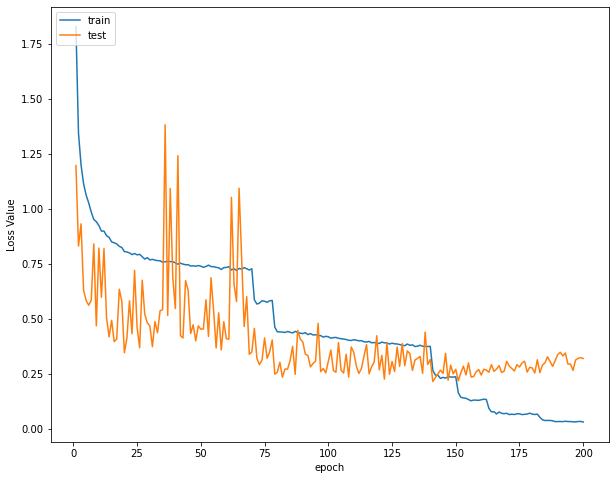

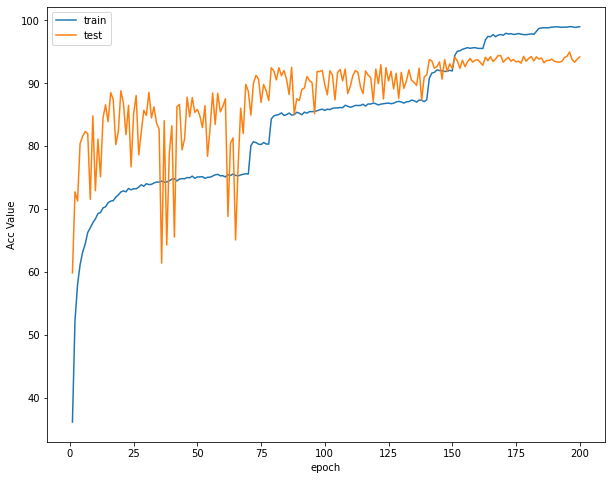

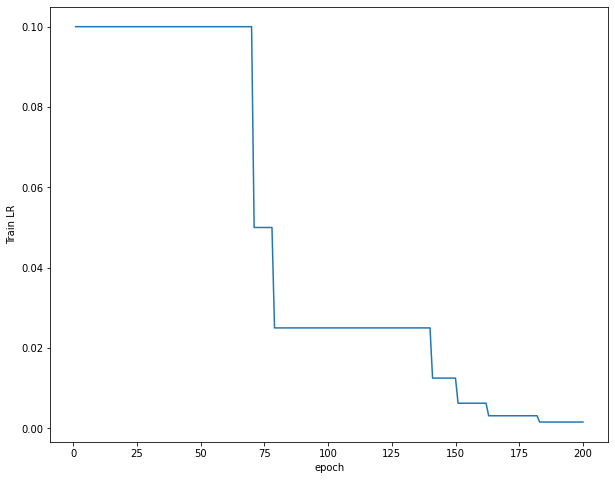

In [ ]:
plot_history(epoch ,Acc, Loss, Lr)